This is an simplified version of Saulius Simcikas's [model](https://forum.effectivealtruism.org/posts/L5EZjjXKdNgcm253H/corporate-campaigns-affect-9-to-120-years-of-chicken-life) of the cost effectiveness of corportate campaigning.

In this example model, the total-cost input is drawn from Salius's guesstimate distribution.  This model only covers egg-laying hens, while Salius's also adresses broiler's chickens.

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# This is our module
import simulator as sim

In [23]:
import importlib
importlib.reload(sim)

<module 'simulator' from '/Users/nix/guesstimate-python/simulator.py'>

First we define the model, _M_.

Currently, a normal input distributions can be created by either by `simulator.Parameter.normal(mean, std)` or by `simulator.Parameter.normal_from_range(low, high)` for a subjective confidence interval.  These distributions can then be combined through use of normal python operators `+, -, *, \`.  There is currently no support anything except these basic operations and (log)normal distributions.

In [24]:
M = sim.Model()

# The Parameter class, for easy access to creation routines for Parameter objects. 
P = sim.Parameter

# First we calculate the number of hens that would be affected with 100% commtiment rate
us_commitments = P.normal(ci=[210e6, 270e6])
us_p_cage_free_anyway = P.lognormal(ci=[.18, .26])
us_counterfactual = us_commitments * (1 - us_p_cage_free_anyway)

int_commitments = P.lognormal(ci=[100e6, 300e6])
int_p_cage_free_anyway = P.normal(ci=[.2, .5])
int_counterfactual = int_commitments * (1 - int_p_cage_free_anyway)

tot_counterfactual = us_counterfactual + int_counterfactual

# We can register the adjustable input parameters alongside engish names/descriptions
# This will potentially happen automatically in the future, unsure exactly what makes sense
M.add_inputs({
    "us commitments (hens)": us_commitments,
    "us proportion cage free anyway": us_p_cage_free_anyway,
    "international commitments (hens)": int_commitments,
    "international proportion cage free anyway": int_p_cage_free_anyway
})


# Total spending is taken by sampling outputs from the guesstimate distribution in order to not
# have to replicate the whole calculation.  This is done by copy and pasting samples from
# guesstimateinto a file which can then be read by our model.
# `P.sample_dist(list)` just randomly samples outcomes from `list`
tot_spending = P.sample_dist(np.loadtxt("spending samples.txt"))
ideal_per_dollar_per_year = tot_counterfactual / tot_spending

us_follow_through = P.lognormal(ci=[.33, .85])
int_follow_through = P.normal(ci=[.63, .9])

# The follow through rate (a weighted average of us and internation follow through)
follow_through = (us_follow_through*us_counterfactual + \
    int_follow_through* int_counterfactual) / tot_counterfactual

hens_per_year_per_dollar = follow_through * ideal_per_dollar_per_year
years_of_impact = P.lognormal(ci=[4, 36])

# Our final output
hen_years_per_dollar = hens_per_year_per_dollar * years_of_impact

M.add_inputs({
    "total spending": tot_spending,
    "us follow through": us_follow_through,
    "international follow through": int_follow_through,
    "years of impact": years_of_impact
})
M.add_params({
    "US counterfactual": us_counterfactual,
    "Interational counterfactual": int_counterfactual,
    "Total counterfactual": tot_counterfactual,
    "Follow through": follow_through,
    "Hens per year, per dollar": hens_per_year_per_dollar,
    "Hen years affected per dollar": hen_years_per_dollar
})

In [25]:
def print_parents(param, prefix="- "):
    if param.name is not None:
        print(prefix + param.name)
    for parent in param.parents:
        if parent.name is None:
            print_parents(parent, prefix)
        else:
            print_parents(parent, '\t' + prefix)
        
print_parents(hen_years_per_dollar)

- Hen years affected per dollar
	- Hens per year, per dollar
		- Follow through
			- us follow through
			- US counterfactual
				- us commitments (hens)
				- us proportion cage free anyway
			- international follow through
			- Interational counterfactual
				- international commitments (hens)
				- international proportion cage free anyway
			- Total counterfactual
				- US counterfactual
					- us commitments (hens)
					- us proportion cage free anyway
				- Interational counterfactual
					- international commitments (hens)
					- international proportion cage free anyway
		- Total counterfactual
			- US counterfactual
				- us commitments (hens)
				- us proportion cage free anyway
			- Interational counterfactual
				- international commitments (hens)
				- international proportion cage free anyway
		- total spending
	- years of impact


Now that we've created the model we can graph the sampled results for parameters of interest:

5th:  5.52
mean: 50.10
95th: 159.77

std: 70.2719



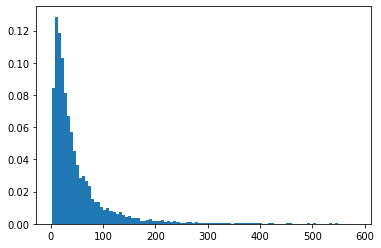

In [26]:
hen_years_per_dollar.print_summary();

We can also graph the correlations between one variable and all the input distributions.  Note this uses the english names that we registered the input variables with!

In [27]:
M.input_r2s(hen_years_per_dollar);

Input                                         r^2
-----------------------------------------  ------
years of impact                            0.5763
us follow through                          0.0509
international commitments (hens)           0.0423
total spending                             0.0276
us proportion cage free anyway             0.0028
international proportion cage free anyway  0.0019
us commitments (hens)                      0.0013
international follow through               0.0011


Or look at scatterplots for the correlations between two variables:

slope: 3.0764573540161693
intercept: -1.739280054317554
r^2: 0.576270322712236


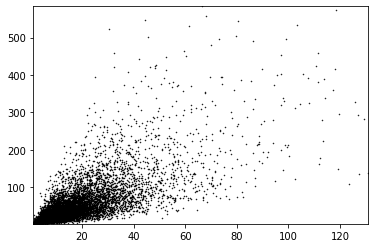

In [28]:
M.sensitivity(years_of_impact, hen_years_per_dollar)

Or create a graph comparing the outcome for the lowest 10% of sampled inputs for total spending (blue) to the highest 10% (orange).

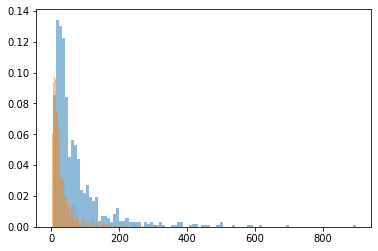

In [29]:
M.sensitivty_comparisons(tot_spending, hen_years_per_dollar)